<a href="https://colab.research.google.com/github/ejihoon6065/Project_TurnAround/blob/master/SARIMA_2020_10_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set() # setting seaborn default for plots
import matplotlib.font_manager as fm
import copy
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
import numpy as np


from scipy import stats  # Box-Cox 검정
import statsmodels.api as sm  # qqplot
from statsmodels.tsa.stattools import adfuller    # adfuller : ADF그래프 그려주는 함수
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.stats.diagnostic import acorr_ljungbox # Ljung-Box 검정

import warnings
warnings.filterwarnings("ignore")

import itertools


# 돌리기전에, https://colab.research.google.com/drive/1oBXX3k3OOjdivwlDhpLmAqfq5B5dzFR1#scrollTo=AbTlhWommsXE 에 있는 코드도 참고 
# https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a 참고

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install -U pykrx  # KRX데이터를 크롤링하기 위한 라이브러리설치

     |████████████████████████████████| 40kB 1.8MB/s 
     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 245kB 20.8MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from datetime import datetime,timedelta

today=datetime.today().strftime("%Y%m%d")                      # 현재날짜
year1=(datetime.today()-timedelta(365)).strftime('%Y%m%d')     # 현재날짜로부터 1년전 날짜

In [9]:
print(today,year1)

20201007 20191008


In [10]:
# 주가 크롤링
from pykrx import stock
df = stock.get_market_ohlcv_by_date(year1, today, "122870")  # (시작날짜,종료날짜,종목번호)
df

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-10-08,23400,23900,22900,23800,148848
2019-10-10,23550,23700,23000,23550,150525
2019-10-11,23800,25200,23650,23950,474910
2019-10-14,24350,25850,24150,25650,558471
2019-10-15,25600,26700,25350,26000,425303
...,...,...,...,...,...
2020-09-28,52300,57500,51800,57000,1067907
2020-09-29,57700,58000,54900,58000,758762
2020-10-05,57100,57400,51800,52500,1428801


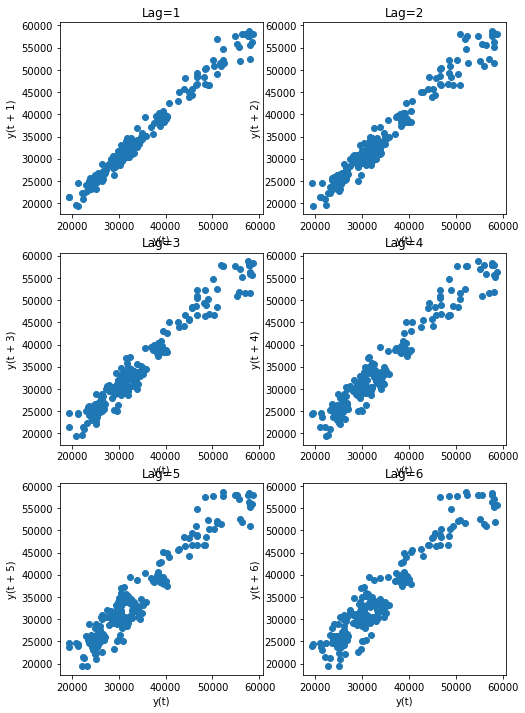

In [11]:
# 선형 모델 적용이 적합한지 확인해보기  (Scatter_plot의 모양이 선형일 수록, 선형모델적용이 타당한 것으로 해석 가능)

from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('YG Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df['종가'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

# 그래프의 해석 결과: 
# A linear shape to the plot suggests that an autoregressive model is probably a better choice.
# An elliptical plot suggests that the data comes from a single-cycle sinusoidal model.

In [12]:
df.shape 

(248, 5)

In [13]:
# train, validfate, testset으로 나누는데, 금융 시계열 데이터이므로, one-step forecast validation 필요 
# https://neocarus.tistory.com/entry/%EB%AA%A8%ED%98%95%EC%9D%98-%EC%A0%81%ED%95%A9%EC%84%B1%EC%97%90-%EB%8C%80%ED%95%9C-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D%EC%9D%84-%EC%88%98%ED%96%89%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95 참고

# train -> 선학습
# validation_set의 one-step forecast validation 하기위한 과정
# 이후, test개수만큼 predict 필요

# 개수로 247개 -> train : 207개, validation : 30개, test : 10개로 개수로 데이터셋나눌수 있도록 

print(df.shape)

# 조정가능한 값 (validation_size , test_size)
validation_size=40  # (2달)
test_size=10        # (2주)

train=df[:len(df)-validation_size]
validation=df[len(df)-validation_size:len(df)-test_size]
test=df[len(df)-test_size:]

print(train.shape)
print(validation.shape)
print(test.shape)

(248, 5)
(208, 5)
(30, 5)
(10, 5)


In [14]:
# column들 중, 종가만 고려한다
train.drop(['시가', '고가','저가','거래량'], axis='columns', inplace=True)
validation.drop(['시가', '고가','저가','거래량'], axis='columns', inplace=True)
test.drop(['시가', '고가','저가','거래량'], axis='columns', inplace=True)

In [15]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 808kB 17.3MB/s 
     |████████████████████████████████| 2.1MB 11.9MB/s 
     |████████████████████████████████| 8.7MB 38.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [16]:
from pmdarima import auto_arima
import pmdarima as pm
auto = pm.auto_arima(y=train, d=1, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=60,
                            seasonal=True,
                            D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True,
                            stepwise=True,
                            max_order=None)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,0)[60]             : AIC=2560.972, Time=1.37 sec
 ARIMA(1,1,0)(1,1,0)[60]             : AIC=2558.243, Time=8.34 sec
 ARIMA(0,1,1)(0,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,0)[60]             : AIC=2562.708, Time=0.75 sec
 ARIMA(1,1,0)(2,1,0)[60]             : AIC=2550.918, Time=43.61 sec
 ARIMA(1,1,0)(2,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(1,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(2,1,0)[60]             : AIC=2547.356, Time=37.36 sec
 ARIMA(0,1,0)(1,1,0)[60]             : AIC=2557.436, Time=5.11 sec
 ARIMA(0,1,0)(2,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,1,1)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(2,1,0)[60]             : AIC=2551.342, Time=46.91 sec
 ARIMA(1,1,1)(2,1,0)[60]             : AIC=inf, Time=213.26 sec
 ARIMA(0,1,0)(2,1,0)[60] intercept   : AIC=2550.850, Ti

In [17]:
result_seasonal=auto.fit(train)
print(result_seasonal.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  208
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 60)   Log Likelihood               -1270.678
Date:                            Wed, 07 Oct 2020   AIC                           2547.356
Time:                                    11:27:52   BIC                           2556.327
Sample:                                         0   HQIC                          2551.001
                                            - 208                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L60      -0.3012      0.047     -6.464      0.000      -0.393      -0.210
ar.S.L120     -0.2606      0.041   

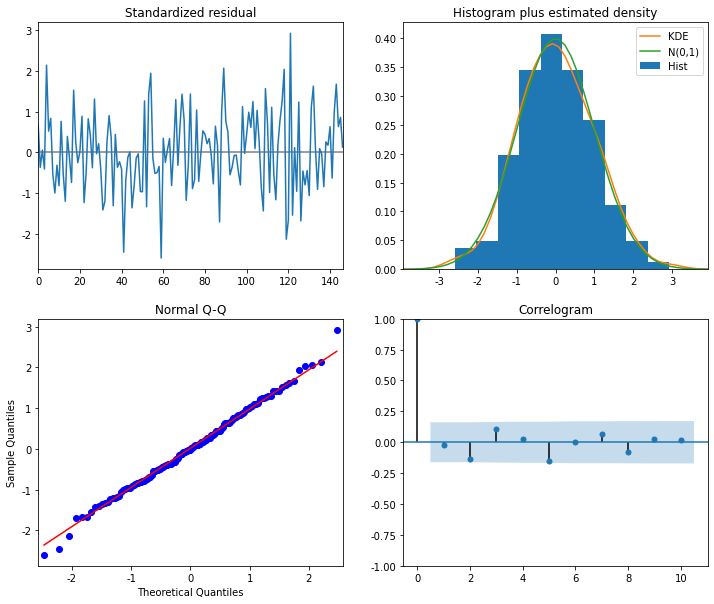

In [18]:
result_seasonal.plot_diagnostics(figsize=(12,10))          
plt.show()  

# 잡음(불규칙요인)의 분포 살피기 (표준잔차, 잔차분포, Normal Q-Q (QQ-Plot), 상관성)

# https://data.library.virginia.edu/diagnostic-plots/ 참고

# 표준화 잔차 (Standardized residual) : 추정 회귀식으로부터 관측치가 얼마나 떨어져 있는지, 절댓값 3이상이면 이상값이 확실, 연구자에 따라 2~3사이의 값을 이상값일 가능성이 달라짐.
# 잔차분포 (Histogram plus estimated density) :  KDE - 커널밀도추정 (정규분포를 스무딩한 것) ( https://darkpgmr.tistory.com/147 참고 ) - 잔차분포(N(0,1))가 KDE와 비슷하다 즉, 잔차가 정규분포 다시말해 회귀모델의 가정중 하나인 잔차가 독립이라는 것을 따른다는 이야기  
# QQ-plot (Normal-QQ) : 수집 데이터를 표준정규분포의 분위수와 비교하여 그리는 그래프 -> 데이터의 정규성 가정에 대한 검토를 가능하게 해줌 -> 집단이 정규성을 따른다면, 점들이 직선의 형태로 그려짐.
# 상관성 (Correlogram): ACF 그래프 

In [19]:
model = auto  # seeded from the model we've already fit (trainset으로 이미 학습된 모델)

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    #print('fc : ',fc)
    #print('conf_int : ',conf_int)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []
errors = [] 


df_validation=df[validation.index[0]:validation.index[-1]]

for i in range(len(df_validation['종가'])):
  fc, conf = forecast_one_step()
  forecasts.append(fc)
  confidence_intervals.append(conf)
  errors.append(fc-df_validation['종가'][i])
  print('Error : ',fc-df_validation['종가'][i],' / y_pred : ',fc,' / y(종가) : ',df_validation['종가'][i],' / 저가 : ',df_validation['저가'][i],' / 고가 : ',df_validation['고가'][i])
  # Updates the existing model with a small number of MLE steps
  model.update(df_validation['종가'][i])

Error :  493.29447246261407  / y_pred :  44443.294472462614  / y(종가) :  43950  / 저가 :  43750  / 고가 :  45350
Error :  -1159.0317709247538  / y_pred :  44440.968229075246  / y(종가) :  45600  / 저가 :  43400  / 고가 :  46100
Error :  1701.031494506533  / y_pred :  47401.03149450653  / y(종가) :  45700  / 저가 :  44850  / 고가 :  46400
Error :  1483.268996964296  / y_pred :  45733.268996964296  / y(종가) :  44250  / 저가 :  43600  / 고가 :  45800
Error :  -4431.951700238053  / y_pred :  43818.04829976195  / y(종가) :  48250  / 저가 :  45700  / 고가 :  50800
Error :  -983.8776544030989  / y_pred :  47516.1223455969  / y(종가) :  48500  / 저가 :  47500  / 고가 :  49450
Error :  1747.8083630998299  / y_pred :  48497.80836309983  / y(종가) :  46750  / 저가 :  46050  / 고가 :  49300
Error :  -2107.5746950878674  / y_pred :  47192.42530491213  / y(종가) :  49300  / 저가 :  46200  / 고가 :  49900
Error :  2739.562824449502  / y_pred :  49239.5628244495  / y(종가) :  46500  / 저가 :  46000  / 고가 :  48800
Error :  -1439.7100868656926  / y_pre

In [25]:
errors_abs=np.abs(errors)

print('오차절대값의 최대 : ',np.max(errors_abs))
print('오차절대값의 최소 : ',np.min(errors_abs))

오차절대값의 최대 :  4431.951700238053
오차절대값의 최소 :  115.20759321980586


In [26]:
df_validation

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2020-08-07,44950,45350,43750,43950,426223
2020-08-10,44900,46100,43400,45600,863517
2020-08-11,46150,46400,44850,45700,421615
2020-08-12,45750,45800,43600,44250,455990
2020-08-13,46150,50800,45700,48250,2380126
2020-08-14,48450,49450,47500,48500,712309
2020-08-18,49000,49300,46050,46750,720514
2020-08-19,46750,49900,46200,49300,857261
2020-08-20,48800,48800,46000,46500,642998


In [27]:
errors=pd.DataFrame(errors,columns={'오차'})
errors=round(errors)  # 주가는 소수단위포함하지 않으므로 소수점 반올림 처리
print('Average Of Error : ',np.mean(errors))
errors

Average Of Error :  오차   -371.966667
dtype: float64


,오차
0,493.0
1,-1159.0
2,1701.0
3,1483.0
4,-4432.0
5,-984.0
6,1748.0
7,-2108.0
8,2740.0
9,-1440.0


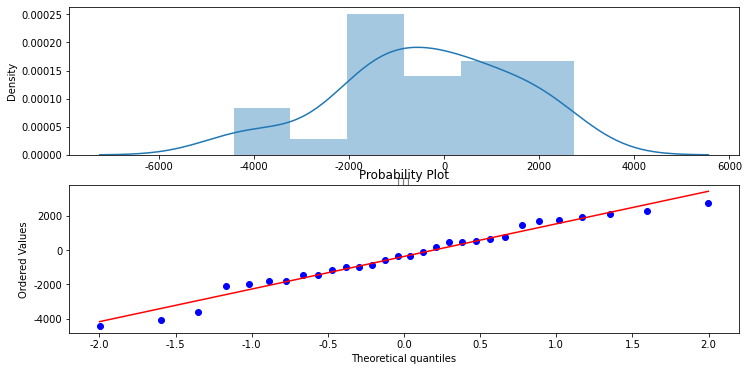

In [28]:
# 오차의 정규성 분포 확인

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sns.distplot(errors['오차'],ax=ax1)
stats.probplot(errors['오차'], plot=ax2)
plt.show()


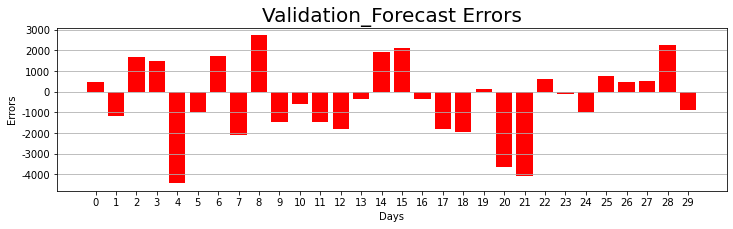

In [29]:
# 예측값과 실제값 차이그래프 확인

plt.figure(figsize=(12, 3))
plt.rcParams['lines.linewidth'] = 1
plt.grid(axis='y')
plt.bar(errors.index, errors['오차'],color='red')
plt.title('Validation_Forecast Errors', fontsize=20)
plt.xlabel('Days', fontsize=10)
plt.ylabel('Errors', fontsize=10)
plt.xticks(errors.index, fontsize=10)
plt.show()

In [30]:
from numpy import array, mean
from scipy.stats import sem, t


def mean_confidence_interval(data, confidence=.999): 
    a = 1.0 * array(data) 
    n = len(a) 
    m, se = mean(a), sem(a)                      # mean : 평균, sem : 평균의 표준오차 
    h = se * t._ppf((1 + confidence) / 2., n - 1) 
    return m, m - h, m + h


avg,floor,cap=mean_confidence_interval(errors)

error_lst=[]
for i in range(len(errors['오차'])):
  if (errors['오차'][i] > cap) | (errors['오차'][i] < floor):
    error_lst.append((i,errors['오차'][i]))

error_lst  

[(2, 1701.0),
 (3, 1483.0),
 (4, -4432.0),
 (6, 1748.0),
 (7, -2108.0),
 (8, 2740.0),
 (12, -1812.0),
 (14, 1938.0),
 (15, 2099.0),
 (17, -1811.0),
 (18, -1964.0),
 (20, -3623.0),
 (21, -4072.0),
 (28, 2270.0)]

In [32]:
temp=[i[0] for i in error_lst]

change_points=pd.DataFrame({'종가':validation['종가'],'날짜':validation.index,'인덱스':range(0,30)})

cp=[]
for i,v in enumerate(change_points.index):
  if i in temp:
    cp.append(v.strftime("%Y-%m-%d"))

In [33]:
cp  # prophet에 들어갈 changingpoint 리스트

['2020-08-11',
 '2020-08-12',
 '2020-08-13',
 '2020-08-18',
 '2020-08-19',
 '2020-08-20',
 '2020-08-26',
 '2020-08-28',
 '2020-08-31',
 '2020-09-02',
 '2020-09-03',
 '2020-09-07',
 '2020-09-08',
 '2020-09-17']

In [34]:
forecasts=pd.DataFrame(forecasts,index=validation.index,columns={'종가'})
forecasts=round(forecasts)

In [36]:
forecasts

,종가
날짜,
2020-08-07,44443.0
2020-08-10,44441.0
2020-08-11,47401.0
2020-08-12,45733.0
2020-08-13,43818.0
2020-08-14,47516.0
2020-08-18,48498.0
2020-08-19,47192.0
2020-08-20,49240.0


In [37]:
test

와이지엔터테인먼트,종가
날짜,
2020-09-21,55600
2020-09-22,55200
2020-09-23,55900
2020-09-24,51900
2020-09-25,50900
2020-09-28,57000
2020-09-29,58000
2020-10-05,52500
2020-10-06,51500


In [38]:
def MPE(y_true,y_pred):  # MPE지표는 따로 라이브러리를 못찾아서 함수를 만듦
    return np.mean((y_true - y_pred) / y_true) * 100

Validation Accuracy : 

Mean squared error(MSE): 3461637.566666667
Mean absolute error(MAE): 1505.5666666666666
Mean absolute percentage error(MAPE): 5018.555555555556
MPE: 0.6726019180721824
RMSE: 1860.5476523504221
SMAPE: 3.0121711412017627


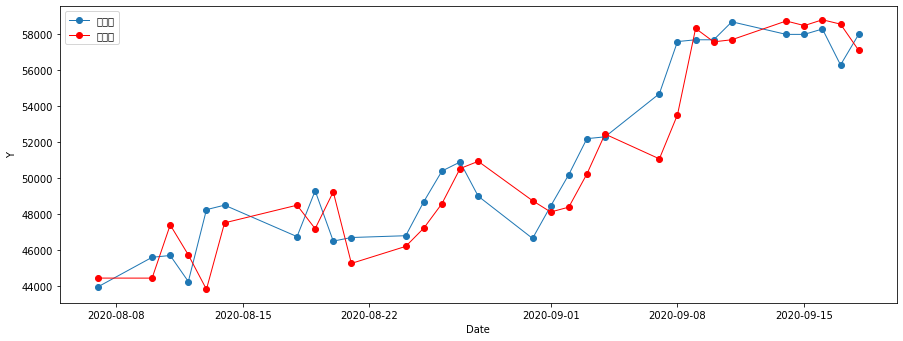

In [39]:
# 현재 설정되어 있는 폰트 사이즈와 글꼴을 알아보자    ( https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/korean_font_on_matplotlib.ipynb#scrollTo=nzZ6wGntXBrP 참고)

# Validation 그래프
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(211)
ax1.plot(validation['종가'],label='실제값',marker='o')
ax1.plot(forecasts['종가'],color='red',label='예측값',marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Y')
ax1.legend(loc=2)
plt.show


from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.metrics import mean_absolute_error
# https://partrita.github.io/posts/regression-error/ 참고

print('Validation Accuracy : \n')
print(f"Mean squared error(MSE): {mean_squared_error(validation, forecasts)}")
print(f"Mean absolute error(MAE): {mean_absolute_error(validation, forecasts)}")
print(f"Mean absolute percentage error(MAPE): {(mean_absolute_error(validation, forecasts))/validation.shape[0]*100}")
print(f"MPE: {MPE(validation['종가'], forecasts['종가'])}")
print(f"RMSE: {mean_squared_error(validation, forecasts)**0.5}")
print(f"SMAPE: {smape(validation, forecasts)}")

In [41]:
fc, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)

In [42]:
# 상한, 하한 담기
cap=[]
floor=[]
for i in conf_int:
  cap.append(i[1])
  floor.append(i[0])

In [43]:
pred=pd.DataFrame({'yhat':fc,'upper':cap,'lower':floor},index=test.index)
pred

,yhat,upper,lower
날짜,,,
2020-09-21,58895.404011,61624.371382,56166.436641
2020-09-22,61230.447916,65089.790582,57371.105250
2020-09-23,61823.980954,66550.691091,57097.270816
2020-09-24,61021.335933,66479.270674,55563.401192
2020-09-25,63449.926993,69552.083541,57347.770444
2020-09-28,63507.911834,70192.489416,56823.334252
2020-09-29,63726.659975,70946.828972,56506.490977
2020-10-05,64262.806573,71981.491905,56544.121240
2020-10-06,65540.939335,73727.841446,57354.037225


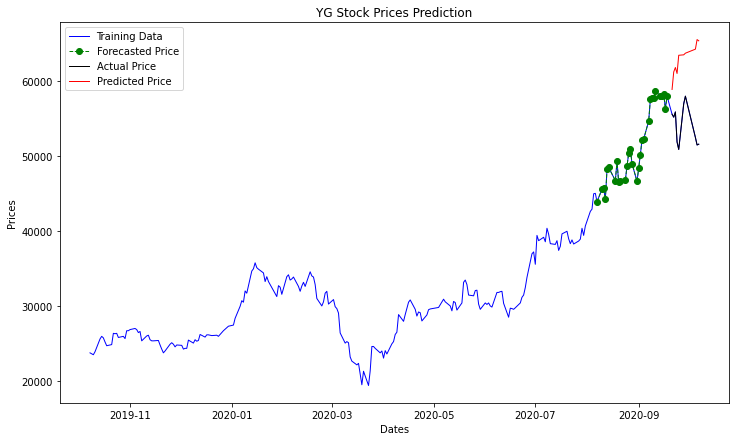

In [45]:
plt.figure(figsize=(12,7))
plt.plot(df['종가'], 'green', color='blue', label='Training Data')
plt.plot(validation.index,validation['종가'],color='green', marker='o', linestyle='dashed', label='Forecasted Price')
plt.plot(test.index, test['종가'], color='black', label='Actual Price')
plt.plot(pred.index, pred['yhat'], color='red', label='Predicted Price')
plt.title('YG Stock Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,7982, 1300), df['Date'][0:7982:1300])
plt.legend()

Testset Accuracy : 

Mean squared error: 3461637.566666667
RMSE: 1860.5476523504221
MPE: 0.6726019180721824
SMAPE: 3.0121711412017627


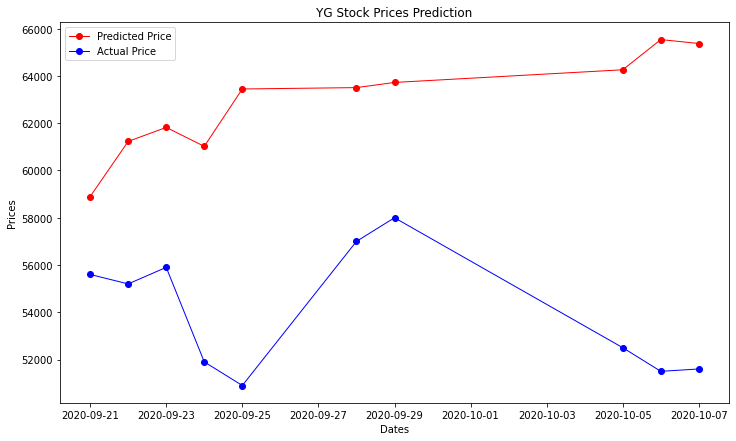

In [44]:
plt.figure(figsize=(12,7))
plt.plot(pred.index, pred['yhat'], color='red',label='Predicted Price',marker='o')
plt.plot(test.index, test['종가'], color='blue', label='Actual Price',marker='o')
plt.legend()
plt.title('YG Stock Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(6386,7982, 300), df['Date'][6386:7982:300])
plt.legend()

print('Testset Accuracy : \n')
print(f"Mean squared error: {mean_squared_error(validation, forecasts)}")

print(f"RMSE: {mean_squared_error(validation, forecasts)**0.5}")
print(f"MPE: {MPE(validation['종가'], forecasts['종가'])}")
print(f"SMAPE: {smape(validation, forecasts)}")

In [ ]:
'''
<오차지표>
https://m.blog.naver.com/pmw9440/221813530210 참고

MS: mean squared error
RMSE: root mean squared error
MAE: mean absolute error
MAPE: mean absolute percent error
MDAPE: median absolute percent error
SMAPE: 

'''

In [ ]:
'''
n_steps = 5
training_period = 0 + n_steps
end = len(df) - n_steps - training_period - 10
validation_size = 20
start = end - validation_size
print('start : ',start,'/ end : ',end,'/ validation_size : ',validation_size,'/ n_step : ',n_steps,'/ training_period : ',training_period)

for i in range(start,end):
  data = df[i:i+training_period+n_steps]

'''